# Notebook initialization

## Selecting best GPU

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import gpustat

stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = 3#min(zip(ids, ratios), key=lambda x: x[1])[0]

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)

setGPU: Setting GPU to: 3


##  Global variables

In [2]:
# IPython extension to reload modules before executing user code.
# 'autoreload' reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "../")

simulation_id = 3
weights_id = 6

weights_path = lambda name: '../weights/{}/{}/'.format(weights_id, name)
figures_path = lambda name: 'figures/{}/{}/'.format(simulation_id, name)

## Seed initialization (for reproductible results)

In [3]:
# Setting the seed for NumPy generated random numbers
import numpy as np
np.random.seed(0)

# Setting the seed for Python random numbers
import random as rn
rn.seed(0)

# Setting the seed for TensorFlow random numbers
import tensorflow as tf
tf.set_random_seed(0)

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

Using TensorFlow backend.


# Importing weights

In [4]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from collections import defaultdict
from numpy.linalg import norm
import itertools

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import pathlib
import pickle

In [5]:
from math import ceil, floor

In [6]:
from data_utils import *
from keras_utils import *
from models import VGG16_beta
from layca_optimizers import SGD

In [7]:
num_classes = 10

In [8]:
(x_train, y_train), (x_test, y_test) = import_cifar(num_classes)

In [9]:
# Simply loading both the initial and finals weights of our models

models = {  
    'vgg16_sgd_0':      VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    'vgg16_sgd_1':      VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    'vgg16_sgd_2':      VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    
    'vgg16_wdecay_0':   VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.001),
    'vgg16_wdecay_1':   VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.001),
    'vgg16_wdecay_2':   VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.001),
    
    'vgg16_layca_0':    VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    'vgg16_layca_1':    VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    'vgg16_layca_2':    VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0)
} 

In [10]:
for name, model in models.items():
    pathlib.Path(figures_path(name)).mkdir(parents=True, exist_ok=True)

In [11]:
for name, model in models.items():
    model.load_weights(weights_path(name) + 'final/weights-final.hdf5') 

In [12]:
Wn = defaultdict(list)
for name, model in models.items():
    print(name)
    Wn[name] = get_kernel_weights(model)

vgg16_wdecay_2
vgg16_sgd_0
vgg16_layca_1
vgg16_layca_2
vgg16_wdecay_0
vgg16_wdecay_1
vgg16_sgd_1
vgg16_layca_0
vgg16_sgd_2


# Pruning aléatoire sur toutes les couches

In [13]:
def evaluate(model):
    sgd = SGD(lr=0.001, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    scores = model.evaluate(x_test, y_test, verbose=1)
    
    return scores[1]

In [14]:
def get_random(arr, k):
    return np.random.choice(np.arange(arr.size), replace=False, size=int(arr.size * k))

In [15]:
pruning_percentage = np.linspace(0.01, 0.9, 25)
accuracies_random = defaultdict(list)

for model_name in ['vgg16_wdecay_0', 'vgg16_layca_2']:
    
    print(model_name)
    model = models[model_name]
    accuracy = evaluate(model)
    
        
    accuracies_random[model_name].append(accuracy)    
    
    old_weights = Wn[model_name]   
    
    n_weights_list = [weights.size for weights in old_weights]
    
    old_weights_flattened = np.hstack(np.array([weights.flatten() for weights in old_weights]))

    for percentage in pruning_percentage:
        print(percentage)
        #prune and evaluate the pruned model's accuracy 
           
        indices = get_random(old_weights_flattened, percentage)
        print(indices)
        new_weights_flattened = np.copy(old_weights_flattened)
        new_weights_flattened[indices] = 0
        new_weights_flattened = np.split(new_weights_flattened, np.cumsum(n_weights_list)[:-1])

        new_weights = [x.reshape(y.shape) for x,y in zip(new_weights_flattened, old_weights)]
        

        for layer, layer_weights in zip(get_kernel_layer(model), new_weights):
            set_layer_weights(layer, layer_weights)

        print("pruning done")
        accuracy = evaluate(model)
        #reset the model weights
        for layer, layer_weights in zip(get_kernel_layer(model), old_weights):
            set_layer_weights(layer, layer_weights)

        accuracies_random[model_name].append(accuracy)

    
    
    

vgg16_wdecay_0
10000/10000 [==============================] - 6s 621us/step
0.01
[  297300  1544598  9961505 ... 10128397 12517252  9993571]
pruning done
10000/10000 [==============================] - 5s 477us/step
0.04708333333333334
[5619623 2482176  918025 ... 9611907 2252129  467125]
pruning done
10000/10000 [==============================] - 5s 527us/step
0.08416666666666667
[ 4449929  5020259  5355781 ... 11007550 13936303 10403293]
pruning done
10000/10000 [==============================] - 5s 499us/step
0.12125000000000001
[13913229 10440292 12230635 ... 13307020  6591440 13079506]
pruning done
 7104/10000 [====================>.........] - ETA: 1s

KeyboardInterrupt: 

In [63]:
accuracies_random

defaultdict(list,
            {'vgg16_layca_2': [0.8497,
              0.8516,
              0.8331,
              0.7812,
              0.694,
              0.5324,
              0.3391,
              0.1979,
              0.103,
              0.1537,
              0.1001,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1],
             'vgg16_wdecay_0': [0.6591,
              0.6396,
              0.3131,
              0.1742,
              0.1139,
              0.1079,
              0.1227,
              0.1015,
              0.0981,
              0.1,
              0.0979,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
           

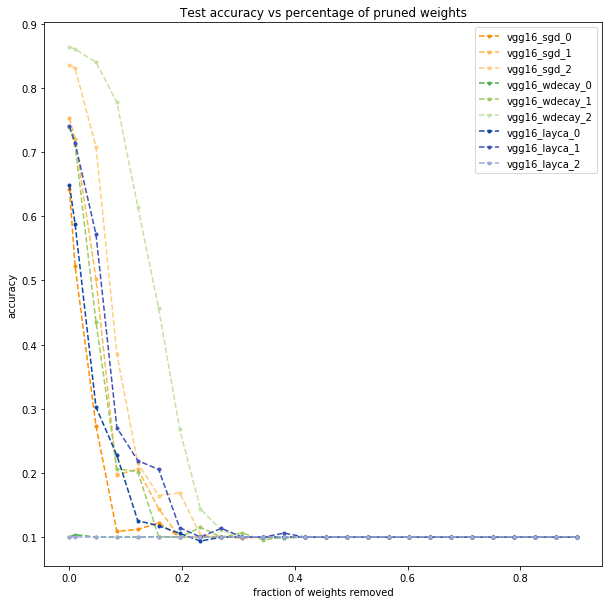

In [50]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set(title='Test accuracy vs percentage of pruned weights', xlabel='fraction of weights removed', ylabel='accuracy')

for color, name in zip(['#FF8F00',
                       '#FFB74D',
                       '#FFCC80',
                       '#4CAF50',
                       '#9CCC65',
                       '#C5E1A5',
                       '#0D47A1',
                       '#3F51B5',
                       '#9FA8DA'], 
                       
                       ['vgg16_sgd_0', 
                        'vgg16_sgd_1', 
                        'vgg16_sgd_2',
                        'vgg16_wdecay_0', 
                        'vgg16_wdecay_1', 
                        'vgg16_wdecay_2', 
                        'vgg16_layca_0', 
                        'vgg16_layca_1', 
                        'vgg16_layca_2']):
    
    ax.plot(pruning_percentage, accuracies_random[name], linestyle='--', marker='o', markersize=3, color=color, label=name)

ax.legend()

plt.show()# fig.savefig(figures_path(name), dpi=100)

# Pruning des plus petits poids sur toutes les couches

In [16]:
def get_indices_of_k_smallest(arr, percentage):
    k = floor(arr.size * percentage)
    idx = np.argpartition(arr, k)
    return idx[:k]

In [18]:
pruning_percentage = np.concatenate(([0], np.linspace(0.01, 0.9, 25)))
accuracies_smallest = defaultdict(list)

for model_name in models:
    
    print(model_name)
    model = models[model_name]
    
    old_weights = Wn[model_name]  
    
    n_weights_list = [weights.size for weights in old_weights]
    
    old_weights_flattened = np.hstack(np.array([weights.flatten() for weights in old_weights]))
    
#     print(old_weights_flattened)
    
    
    for percentage in pruning_percentage:
        print(percentage)
        #prune and evaluate the pruned model's accuracy 
           
        indices = get_indices_of_k_smallest(np.abs(old_weights_flattened), floor(percentage*old_weights_flattened.size))

        new_weights_flattened = np.copy(old_weights_flattened)
        new_weights_flattened[indices] = 0
        new_weights_flattened = np.split(new_weights_flattened, np.cumsum(n_weights_list)[:-1])

        new_weights = [x.reshape(y.shape) for x,y in zip(new_weights_flattened, old_weights)]
        

        for layer, layer_weights in zip(get_kernel_layer(model), new_weights):
            set_layer_weights(layer, layer_weights)

        accuracy = evaluate(model)
        #reset the model weights
        for layer, layer_weights in zip(get_kernel_layer(model), old_weights):
            set_layer_weights(layer, layer_weights)

        accuracies_smallest[model_name].append(accuracy)

vgg16_wdecay_2
[ 0.19483575  0.00800833  0.04586625 ...  0.0150818   0.01485922
 -0.00164551]
vgg16_sgd_0
[-0.00452643  0.06209011  0.10750221 ... -0.06042222 -0.01938702
 -0.09906074]
vgg16_layca_1
[ 0.02192321  0.05928252  0.08611783 ... -0.03834016 -0.01655373
 -0.08170983]
vgg16_layca_2
[-0.06421139 -0.04090443 -0.06039381 ...  0.02468557  0.05800036
  0.06578784]
vgg16_wdecay_0
[ 0.02973024  0.05057167  0.09664436 ... -0.04777459 -0.01820144
 -0.09261438]
vgg16_wdecay_1
[ 0.02044936 -0.02246441  0.08752041 ... -0.04205569 -0.0150837
 -0.09771103]
vgg16_sgd_1
[ 0.06694181  0.04998274  0.10358617 ... -0.05328968 -0.01863026
 -0.0948158 ]
vgg16_layca_0
[ 0.0198356   0.06428534  0.08872054 ... -0.04418525 -0.02616141
 -0.09072132]
vgg16_sgd_2
[-0.09311914 -0.21517679  0.7405303  ... -0.1737446   0.0421043
 -0.10908963]


In [16]:
accuracies_smallest

defaultdict(list,
            {'vgg16_layca_0': [0.6488,
              0.6488,
              0.6485,
              0.6482,
              0.6482,
              0.6475,
              0.6436,
              0.639,
              0.6219,
              0.5969,
              0.5489,
              0.5148,
              0.5013,
              0.4486,
              0.3815,
              0.3419,
              0.3018,
              0.2097,
              0.1314,
              0.1122,
              0.1162,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1],
             'vgg16_layca_1': [0.7404,
              0.7405,
              0.7401,
              0.7418,
              0.741,
              0.7408,
              0.738,
              0.7342,
              0.7259,
              0.7244,
              0.7089,
              0.7043,
              0.686,
              0.6679,
              0.6298,
              0.5864,
              0.5373,
              0.4571

In [37]:
pruning_percentage = np.concatenate(([0], np.linspace(0.01, 0.9, 25)))
accuracies_smallest = defaultdict(list)

for model_name in ['vgg16_sgd_2', 'vgg16_wdecay_2', 'vgg16_layca_2']:
    
    print(model_name)
    model = models[model_name]
    
    old_weights = Wn[model_name]  
    
    n_weights_list = [weights.size for weights in old_weights]
    
    old_weights_flattened = np.hstack(np.array([weights.flatten() for weights in old_weights]))
    
#     print(old_weights_flattened)
    
    n_removed_layers = [0]*15
    
    percentage = 0.4

    indices = get_indices_of_k_smallest(np.abs(old_weights_flattened), percentage)

    separation = [0] + np.cumsum(n_weights_list).tolist()

    for index in indices:
        for i in range(len(separation)-1):
            if separation[i] <= index and index < separation[i+1]:
                n_removed_layers[i] += 1

    
    print(n_removed_layers)
                    


vgg16_sgd_2
[27, 2577, 6590, 17881, 46174, 125047, 133299, 386324, 1007756, 1050233, 1068133, 1063692, 1041464, 41464, 430]
vgg16_wdecay_2
[8, 880, 2354, 5482, 14366, 43950, 45021, 161250, 647170, 762464, 1208204, 1448033, 1612878, 38864, 167]
vgg16_layca_2
[184, 4512, 11218, 24918, 63132, 144354, 142958, 353351, 831904, 867546, 1056714, 1180559, 1280976, 28232, 533]


In [40]:
sgd_removed = [27, 2577, 6590, 17881, 46174, 125047, 133299, 386324, 1007756, 1050233, 1068133, 1063692, 1041464, 41464, 430]
wdecay_removed = [8, 880, 2354, 5482, 14366, 43950, 45021, 161250, 647170, 762464, 1208204, 1448033, 1612878, 38864, 167]
layca_removed = [184, 4512, 11218, 24918, 63132, 144354, 142958, 353351, 831904, 867546, 1056714, 1180559, 1280976, 28232, 533]

for model_name, removed in zip(['vgg16_sgd_2', 'vgg16_wdecay_2', 'vgg16_layca_2'],
                               [sgd_removed, wdecay_removed, layca_removed]):
    
    print(model_name)
    model = models[model_name]
    
    old_weights = Wn[model_name]  
    
    n_weights_list = [weights.size for weights in old_weights]
    print(np.array(removed)/np.array(n_weights_list)*100)



vgg16_sgd_2
[ 1.5625      6.9905599   8.93825955 12.12632921 15.65687391 21.20073107
 22.59979248 32.74909125 42.71426731 44.51467726 45.27337816 45.08514404
 44.14299859 15.81726074  8.3984375 ]
vgg16_wdecay_2
[ 0.46296296  2.38715278  3.19281684  3.71771918  4.87128364  7.45137533
  7.63295492 13.66933187 27.43064033 32.31743707 51.21036106 61.37563917
 68.36268107 14.82543945  3.26171875]
vgg16_layca_2
[10.64814815 12.23958333 15.21538628 16.89860026 21.4070638  24.4740804
 24.23739963 29.95393541 35.26068793 36.77139282 44.78937785 50.03861321
 54.29484049 10.76965332 10.41015625]


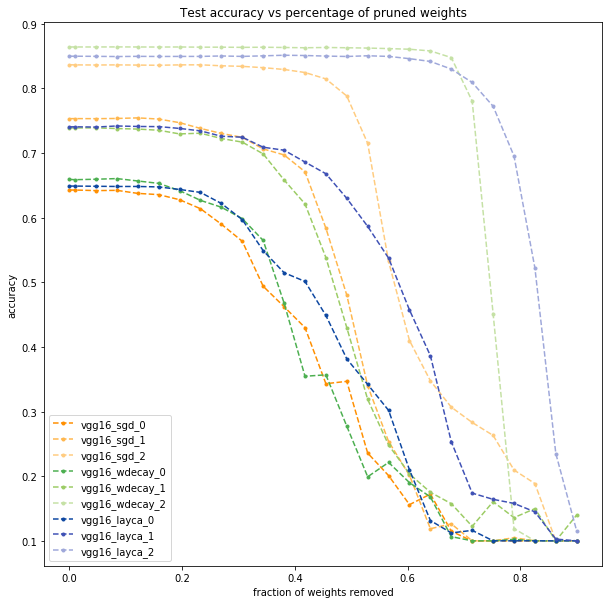

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set(title='Test accuracy vs percentage of pruned weights', xlabel='fraction of weights removed', ylabel='accuracy')

for color, name in zip(['#FF8F00',
                       '#FFB74D',
                       '#FFCC80',
                       '#4CAF50',
                       '#9CCC65',
                       '#C5E1A5',
                       '#0D47A1',
                       '#3F51B5',
                       '#9FA8DA'], 
                       
                       ['vgg16_sgd_0', 
                        'vgg16_sgd_1', 
                        'vgg16_sgd_2',
                        'vgg16_wdecay_0', 
                        'vgg16_wdecay_1', 
                        'vgg16_wdecay_2', 
                        'vgg16_layca_0', 
                        'vgg16_layca_1', 
                        'vgg16_layca_2']):
    
    ax.plot(pruning_percentage, accuracies_smallest[name], linestyle='--', marker='o', markersize=3, color=color, label=name)

ax.legend()

plt.show()# fig.savefig(figures_path(name), dpi=100)

# Pruning quelconque ciblé sur une couche

In [16]:
cosines = defaultdict(list)

for name, model in models.items():
    print(name)
    model.load_weights(weights_path(name) + 'initial/weights-initial.hdf5') 
    initial = [x.flatten() for x in get_kernel_weights(model)]
    model.load_weights(weights_path(name) + 'final/weights-final.hdf5') 
    final = [x.flatten() for x in get_kernel_weights(model)]
    
    cosines[name] = [cosine_distance(x, y) for x, y in zip(initial, final)]
    

vgg16_wdecay_2
vgg16_layca_1
vgg16_sgd_0
vgg16_sgd_2
vgg16_layca_2
vgg16_wdecay_0
vgg16_layca_0
vgg16_wdecay_1
vgg16_sgd_1


In [18]:
cosines = defaultdict(list,
            {'vgg16_layca_0': [0.0007712841033935547,
              0.0011420249938964844,
              0.0018960237503051758,
              0.002545773983001709,
              0.0026547908782958984,
              0.0030586719512939453,
              0.003387272357940674,
              0.0028519630432128906,
              0.0029976367950439453,
              0.0030306577682495117,
              0.0025877952575683594,
              0.003088533878326416,
              0.003507852554321289,
              0.006363868713378906,
              0.006876766681671143],
             'vgg16_layca_1': [0.0067291259765625,
              0.00897282361984253,
              0.011433303356170654,
              0.013671398162841797,
              0.013702154159545898,
              0.014895498752593994,
              0.015863537788391113,
              0.01364225149154663,
              0.014317572116851807,
              0.0145455002784729,
              0.013293564319610596,
              0.015197575092315674,
              0.015586018562316895,
              0.018442928791046143,
              0.019870758056640625],
             'vgg16_layca_2': [0.8619557023048401,
              0.9857603330165148,
              0.9905513217672706,
              0.9958969759754837,
              0.9978173370473087,
              0.9964304971508682,
              0.9979373260866851,
              0.9998369624227053,
              0.9973885756917298,
              0.9986555505311117,
              0.9977590488269925,
              0.9980746773071587,
              0.9990421265829355,
              0.9974161298014224,
              0.892980732023716],
             'vgg16_sgd_0': [0.026386916637420654,
              0.004568576812744141,
              0.005549907684326172,
              0.004350423812866211,
              0.004556119441986084,
              0.0036170482635498047,
              0.003097832202911377,
              0.002601325511932373,
              0.001861870288848877,
              0.0014901161193847656,
              0.0010194778442382812,
              0.0008956789970397949,
              0.0008553266525268555,
              0.00012564659118652344,
              0.0017935633659362793],
             'vgg16_sgd_1': [0.15893244743347168,
              0.027887940406799316,
              0.026823759078979492,
              0.02175348997116089,
              0.022423088550567627,
              0.018745779991149902,
              0.017350852489471436,
              0.01282656192779541,
              0.00833892822265625,
              0.006349325180053711,
              0.0041841864585876465,
              0.003559291362762451,
              0.0035608410835266113,
              0.0007209181785583496,
              0.009061992168426514],
             'vgg16_sgd_2': [0.8882360234856606,
              0.7256588935852051,
              0.6901594698429108,
              0.6340128779411316,
              0.6070399880409241,
              0.5355206727981567,
              0.5039914548397064,
              0.4098637104034424,
              0.29941678047180176,
              0.24925512075424194,
              0.22769105434417725,
              0.24294662475585938,
              0.2939367890357971,
              0.2005099058151245,
              0.3973986506462097],
             'vgg16_wdecay_0': [0.02788710594177246,
              0.005406618118286133,
              0.006430864334106445,
              0.005155980587005615,
              0.005435943603515625,
              0.004426121711730957,
              0.0038425326347351074,
              0.0031536221504211426,
              0.002268671989440918,
              0.0018151402473449707,
              0.0012073516845703125,
              0.0010960698127746582,
              0.0010477304458618164,
              0.00016498565673828125,
              0.00204312801361084],
             'vgg16_wdecay_1': [0.1420663595199585,
              0.024518370628356934,
              0.025100409984588623,
              0.02064192295074463,
              0.021773695945739746,
              0.018474161624908447,
              0.017087996006011963,
              0.012843012809753418,
              0.008571922779083252,
              0.006528675556182861,
              0.004141449928283691,
              0.003607451915740967,
              0.003556370735168457,
              0.0007641911506652832,
              0.009538471698760986],
             'vgg16_wdecay_2': [0.9267788156867027,
              0.9903173092752695,
              0.9851622190326452,
              0.979076137766242,
              0.984774804674089,
              0.980134466663003,
              0.9784937184303999,
              0.9789524096995592,
              0.9728024527430534,
              0.9689783006906509,
              0.9658987633883953,
              0.961491797119379,
              0.962770689278841,
              0.9284686371684074,
              0.8327789008617401]})

## Quels poids ont été retirés?

# Pruning ciblé

In [22]:
accuracies_cible_random = defaultdict(lambda: defaultdict(list))
pruning_percentage = np.concatenate(([0],np.linspace(0.01, 0.9, 25)))

In [57]:
for model_name in ['vgg16_sgd_2']:
    
    print(model_name)
    model = models[model_name]
    
    for layer in get_kernel_layer(model):     

        
        # loading the weights of the layer
        old_weights = get_layer_weights(layer)       

        # calculting the accuracy of the model when pruned by a percentage x of its weights (in the given layer)
        
        for percentage in pruning_percentage:
            if percentage == 0:
                accuracies_cible_random[model_name][layer].append(evaluate(model))
            else:            
                new_weights = np.copy(old_weights).flatten()
                # finding the smallest weights in the layer
                indices = get_random(np.abs(new_weights), percentage)
                # setting them to zero
                new_weights[indices] = 0
                set_layer_weights(layer, new_weights.reshape(old_weights.shape))
                # calculating the accuracy of this new model
                accuracies_cible_random[model_name][layer].append(evaluate(model))
                # resetting the weights for the next iteration
                set_layer_weights(layer, old_weights) 
                
        break

vgg16_sgd_2
10000/10000 [==============================] - 17s 2ms/step


In [ ]:
for i in get_kernel_layer(models['vgg16_sgd_2']):
    print(len(accuracies_cible_random['vgg16_sgd_2'][i]))

In [56]:
layers = get_kernel_layer(models['vgg16_sgd_2'])
accuracies_cible_random['vgg16_sgd_2'][layers[0]] = []

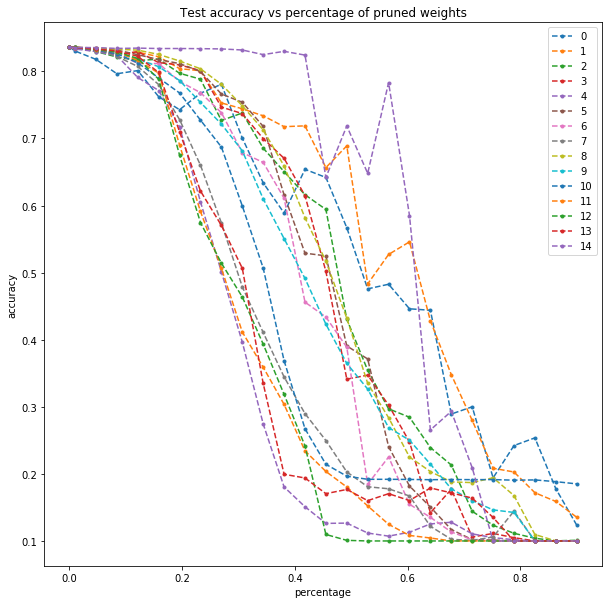

In [60]:
# preparing the plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.set(title='Test accuracy vs percentage of pruned weights', xlabel='percentage', ylabel='accuracy')

for i, layer in enumerate(get_kernel_layer(models['vgg16_sgd_2'])):
    ax.plot(pruning_percentage, accuracies_cible_random['vgg16_sgd_2'][layer], linestyle='--', marker='o', markersize=3, label=i)

ax.legend()

plt.show()# fig.savefig(figures_path(name), dpi=100)

In [ ]:
# preparing the plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.set(title='Test accuracy vs percentage of pruned weights', xlabel='percentage', ylabel='accuracy')

for color, name in zip(['#FF8F00',
                       '#FFB74D',
                       '#FFCC80',
                       '#4CAF50',
                       '#9CCC65',
                       '#C5E1A5',
                       '#0D47A1',
                       '#3F51B5',
                       '#9FA8DA'], 
                       
                       ['vgg16_sgd_0', 
                        'vgg16_sgd_1', 
                        'vgg16_sgd_2',
                        'vgg16_wdecay_0', 
                        'vgg16_wdecay_1', 
                        'vgg16_wdecay_2', 
                        'vgg16_layca_0', 
                        'vgg16_layca_1', 
                        'vgg16_layca_2']):
    
    ax.plot(xs[name], accs[name], linestyle='--', marker='o', markersize=3, color=color, label=name)

ax.legend()

plt.show()# fig.savefig(figures_path(name), dpi=100)

pruning général
pruning sur des layers avec des rotations rate différents
pruning

In [ ]:
pseudo code

for model in models:
    for x in pruning_percentage:
        accuracy = pruning_accuracy(x, fct=random_pruning)
        sum_accuracy += accuracy

    average_accuracy = sum_accuracy/n

print(average_accuracy)

In [16]:
def pruning_accuracy(pruning_fct, layer):    
    # loading the weights of the layer
    old_weights = get_layer_weights(layer)
    
    pruning_percentage = np.concatenate(([0], np.linspace(0.01, 0.9, 18)))
    accuracies = list()
    
    # calculting the accuracy of the model when pruned by a percentage x of its weights (in the given layer)
    for x in pruning_percentage:
        new_weights = np.copy(old_weights)
        # finding the smallest weights in the layer
        indices = pruning_fct(np.abs(new_weights), floor(x*new_weights.size))
        # setting them to zero
        new_weights[indices] = 0
        set_layer_weights(layer, new_weights)
        # calculating the accuracy of this new model
        accuracies.append(evaluate(model))
        # resetting the weights for the next iteration
        set_layer_weights(layer, old_weights)    
        
    return pruning_percentage, accuracies 


# valeur absolue et pas simplement tri (la on retire les poids negatifs et cest pas ce quon veut)
# lire papier pruning
# regarder si les poids de faible amplitude et qui diminue le long du training sont moins importants au niveau pruning
# que les poids de faible amplitude qui ne convergent vers zero

# voir si on a plus de weights intermediaires dans les moins bons modeles. on imagine quun poids intermediaire est 
# nefaste 
        